# Parallelism Demo

Consider $f$ where

$$f(t) = \sum_{k\in\mathbb{N}}^{\infty}(-1)^k\dfrac{\sin[(2k+1) x]}{(2k+1)^2}$$


In [1]:
#import hellaPy
from plt_style import *
#import numpy as np
import cupy  as np
import pylab as plt
import scipy as sp
%matplotlib inline

In [2]:
!nvidia-smi

Mon Aug 31 14:55:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:18:00.0 Off |                    0 |
| N/A   60C    P0   154W / 300W |    546MiB / 32510MiB |     48%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   42C    P0    94W / 300W |    514MiB / 32510MiB |     30%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:
N = 2**25+1
M = N-1
t = np.linspace(0,10*np.pi,N)[:-1]
#f = np.array([ (-1)**k*np.sin((2*k+1)*t)/(2*k+1)**2 for k in range(31) ]).sum(axis=0)
#f = np.sin(t) + np.sin(3*t)/9 + np.sin(5*t)/25


In [4]:
f = 0*t
for k in range(31):
    ell = 2*k+1
    f += (-1)**k*np.sin(ell*t)/ell**2

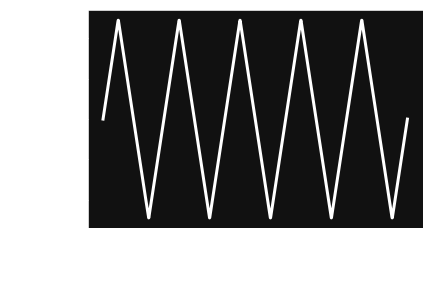

In [5]:
skip = 1000
ts,fs= [ np.asnumpy(u)[::skip] for u in [t,f] ]
plt.plot(ts,fs,'w-',lw=3)
_=plt.xticks(fontsize=20)
_=plt.yticks(fontsize=20)
_=plt.xlabel(r'$t$',fontsize=20,color='w')
_=plt.ylabel(r'$f(t)$',fontsize=20,color='w')

In [6]:
%%time
q = np.abs(np.fft.fft(f)[:M//2])

CPU times: user 183 ms, sys: 95.5 ms, total: 279 ms
Wall time: 354 ms


In [7]:
tau = 10*np.pi
om0 = 2*np.pi/tau
om  = om0*np.asnumpy(np.arange(len(q)))
p   = np.asnumpy(q)
p  /= p.max()
k   = np.asnumpy(np.linspace(1,11,1001))

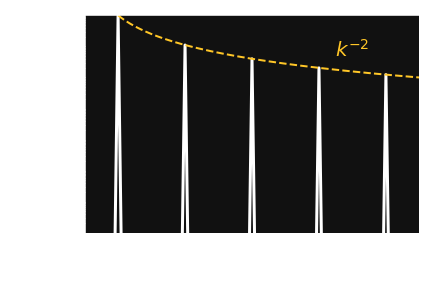

In [8]:
plt.semilogy(om,p,'w-',lw=3)
plt.semilogy(k,1/k**2,'--',c=gld,lw=2)
plt.annotate(r'$k^{-2}$',(8,5e-2),fontsize=20,color=gld,ha='center')
_=plt.xlim(0,10)
_=plt.ylim(1e-7,1)
_=plt.xticks(np.asnumpy(np.arange(10)),fontsize=20)
_=plt.yticks(fontsize=20)
_=plt.xlabel(r'$\omega$',fontsize=20,color='w')
_=plt.ylabel(r'$PSD$',fontsize=20,color='w')

## Einsum on the GPU

Consider 

$$U(x,y,z) = \sum_{\ell\in\mathbb{N}\,odd}^{\infty}\dfrac{\cos(\ell x)\sin(\ell z)}{\ell^3}$$

for $(x,y,z)\in[0,\pi]^3$. Then, in the $xz$-plane, $\partial U/\partial x$ is the cartesian product of two orthogonal triangle waves.

In [26]:
import cheb
import numpy as onp

In [27]:
N = 256
Do,xo = cheb.cheb(256)
D,x = Do*2/np.pi,(xo+1)*np.pi/2
sanity = np.isclose( (D@x).sum()/(N+1),1)
print(f"Sanity: {sanity.__repr__():s}")
Dgpu,xgpu = np.array(D),np.array(x)

Sanity: array(True)


In [28]:
X,Y,Z = onp.meshgrid(x,x,x,indexing='ij')
U = onp.array([ onp.cos(ell*X)*onp.sin(ell*Z)/ell**3 for ell in 2*onp.arange(31)+1 ]).sum(axis=0)

In [29]:
Ugpu = np.array(U)

In [30]:
%%time
dUdx = np.einsum('ij,jkl->ikl',Dgpu,Ugpu)

CPU times: user 640 µs, sys: 3.91 ms, total: 4.55 ms
Wall time: 3.36 ms


In [31]:
dUdx_iter = 0*dUdx

In [32]:
%%time
for k in range(Ugpu.shape[-1]):
    dUdx_iter[:,:,k] = Dgpu @ Ugpu[:,:,k]

CPU times: user 18.3 ms, sys: 406 µs, total: 18.7 ms
Wall time: 17.7 ms


In [33]:
dUdx = np.asnumpy(dUdx)

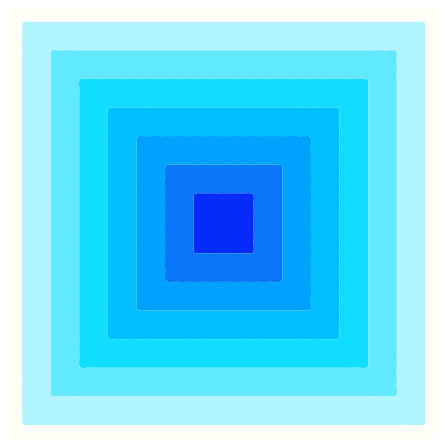

In [34]:
f,a = hellaPy.no_ax_fax()
L   = onp.abs(dUdx).max() * onp.linspace(-1,1,16)
hellaPy.mycontourf(X[:,128,:],Z[:,128,:],dUdx[:,128,:],L,cmap=hellaPy.mycm15)